In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt

#--------------------
# tunable-parameters
#--------------------
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = r"path\to\\Dataset"
bins                   = 8

In [2]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [3]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [4]:
# image segmentation

# for extraction of green and brown color

def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

In [5]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['Apple___Apple_scab', 'Apple___healthy']


In [6]:
# Function to display an image
def display_image(title, image, cmap=None):
    plt.figure(figsize=(6, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [8]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [9]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Detected classes: ['Apple___Apple_scab', 'Apple___healthy']


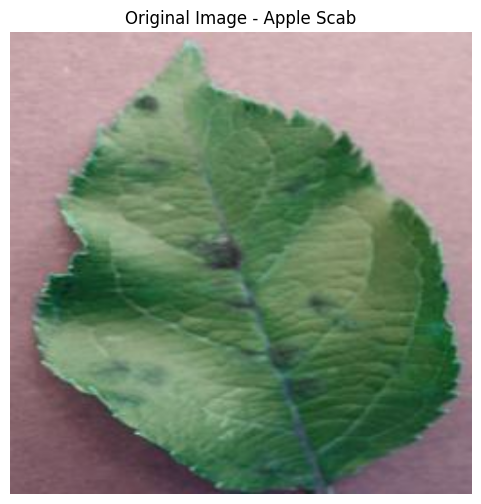

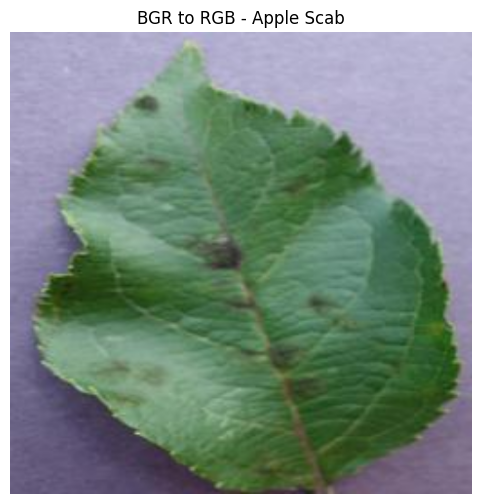

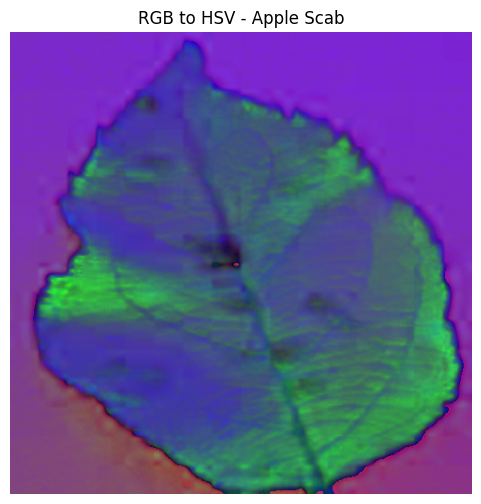

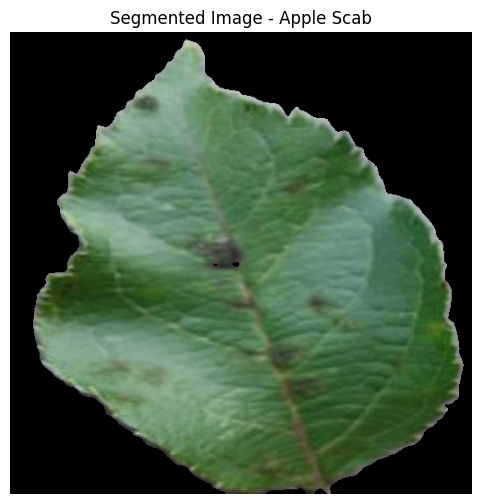

[STATUS] processed folder: Apple___Apple_scab


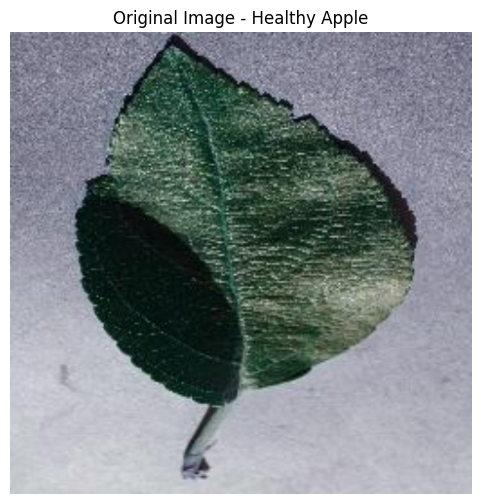

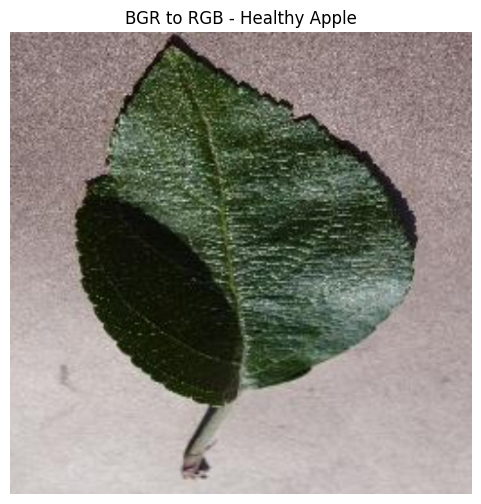

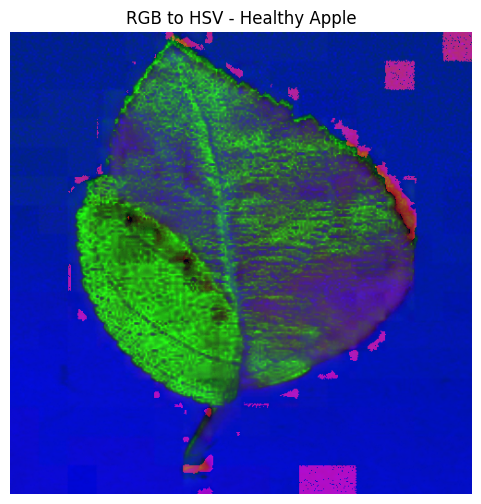

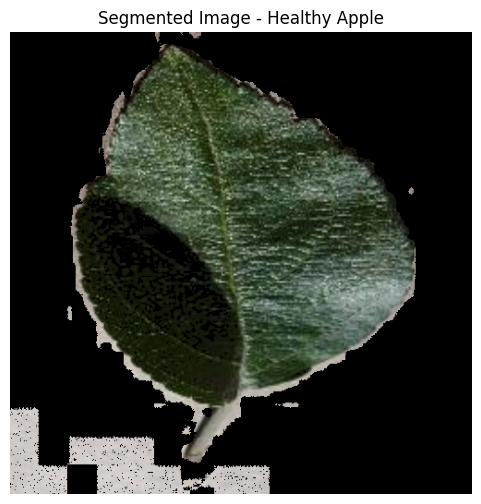

[STATUS] processed folder: Apple___healthy
[STATUS] completed Global Feature Extraction...


In [10]:
train_labels = os.listdir(train_path)
train_labels.sort()
print("Detected classes:", train_labels)
global_features = []
labels = []
# Loop over each folder (class)
# Remove the break condition to ensure all images are processed
for training_name in train_labels:
    # Join the training data path with each species training folder
    dir_path = os.path.join(train_path, training_name)

    # Get the current training label
    current_label = training_name

    # List all image files in the folder
    image_files = os.listdir(dir_path)

    # Ensure the number of images doesn't exceed images_per_class
    image_files = image_files[:images_per_class]

    # Process images in each class
    for file_name in image_files:
        file_path = os.path.join(dir_path, file_name)

        # Read the image
        image = cv2.imread(file_path)
        if image is None:
            print(f"Error loading image: {file_path}")
            continue  # Skip if the image cannot be loaded

        # Resize the image to the fixed size
        image = cv2.resize(image, fixed_size)

        # Process the image through the functions
        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV)

        # Only display results for the first image in each class
        if current_label == "Apple___Apple_scab" and 'scab_displayed' not in locals():
            display_image("Original Image - Apple Scab", image)
            display_image("BGR to RGB - Apple Scab", RGB_BGR)
            display_image("RGB to HSV - Apple Scab", BGR_HSV, cmap='hsv')
            display_image("Segmented Image - Apple Scab", IMG_SEGMENT)
            scab_displayed = True

        if current_label == "Apple___healthy" and 'healthy_displayed' not in locals():
            display_image("Original Image - Healthy Apple", image)
            display_image("BGR to RGB - Healthy Apple", RGB_BGR)
            display_image("RGB to HSV - Healthy Apple", BGR_HSV, cmap='hsv')
            display_image("Segmented Image - Healthy Apple", IMG_SEGMENT)
            healthy_displayed = True

        # Extract and store global features for the image
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate feature vectors
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        # Update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)
        
    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


In [29]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")
print(targetNames)
# Print the size of the target array
print(f"Size of target array: {len(target)}")

# Count and print the number of 0s and 1s
num_zeros = np.sum(target == 0)
num_ones = np.sum(target == 1)

print(f"Number of 0s in target: {num_zeros}")
print(f"Number of 1s in target: {num_ones}")


[STATUS] training labels encoded...
['Apple___Apple_scab' 'Apple___healthy']
Size of target array: 1430
Number of 0s in target: 630
Number of 1s in target: 800


In [12]:
# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [30]:

# Print the dimensions of the feature matrix and target array
print(f"Dimensions of feature matrix (rescaled_features): {rescaled_features.shape}")
print(f"Dimensions of target array: {target.shape}")

Dimensions of feature matrix (rescaled_features): (1430, 532)
Dimensions of target array: (1430,)


In [13]:
# Convert global features and target labels into a DataFrame
features_df = pd.DataFrame(global_features)  # Convert feature vectors to a DataFrame
features_df['Label'] = target  # Add the labels as a new column

# Display the first few rows of the DataFrame
print(features_df.head(5).iloc[:, :5])  # This will print the first 5 rows of the DataFrame


          0         1         2         3         4
0  0.897850  0.000158  0.000260  0.000593  0.001066
1  0.898581  0.000595  0.000390  0.001766  0.001905
2  0.573260  0.000000  0.000217  0.000933  0.000697
3  0.954887  0.000157  0.000024  0.000000  0.000000
4  0.752771  0.000219  0.000493  0.003609  0.002824


In [14]:
# Convert rescaled features and target labels into a DataFrame
re_features_df = pd.DataFrame(rescaled_features)  # Convert feature vectors to a DataFrame
re_features_df['Label'] = target  # Add the labels as a new column

# Display the first few rows of the DataFrame
print(re_features_df.head(5).iloc[:, :5])  # This will print the first 5 rows of the DataFrame

          0         1         2         3         4
0  0.837025  0.034510  0.018451  0.013653  0.007959
1  0.838209  0.130256  0.027749  0.040639  0.014225
2  0.311028  0.000000  0.015401  0.021462  0.005204
3  0.929453  0.034384  0.001674  0.000000  0.000000
4  0.601925  0.048020  0.035074  0.083058  0.021079


In [15]:
print("Sub-folders in train_path:", os.listdir(train_path))

Sub-folders in train_path: ['Apple___Apple_scab', 'Apple___healthy']


In [16]:
# Check unique classes in the labels
unique_labels = np.unique(labels)
print("Unique classes in labels:", unique_labels)
print("Number of samples per class:", {label: labels.count(label) for label in unique_labels})


Unique classes in labels: ['Apple___Apple_scab' 'Apple___healthy']
Number of samples per class: {'Apple___Apple_scab': 630, 'Apple___healthy': 800}


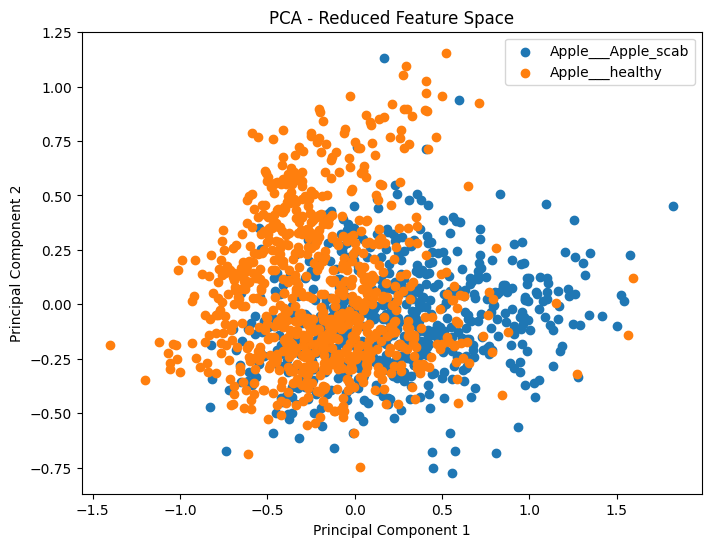

In [17]:
from sklearn.decomposition import PCA
# Reduce to 2 principal components for easy visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(rescaled_features)

# Plot the transformed features
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(target)):
    plt.scatter(features_2d[target == label, 0], features_2d[target == label, 1], label=targetNames[i])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.title("PCA - Reduced Feature Space")
plt.show()


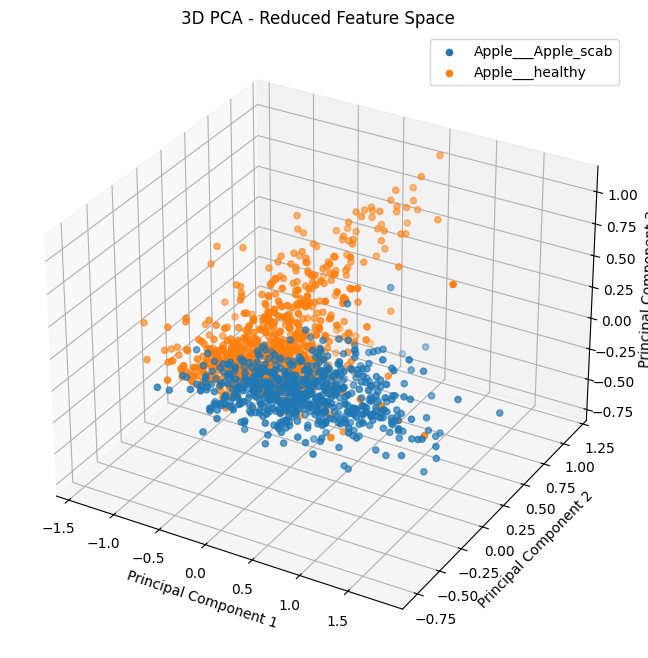

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
features_3d = pca.fit_transform(rescaled_features)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each class in a different color
for i, label in enumerate(np.unique(target)):
    ax.scatter(features_3d[target == label, 0],
               features_3d[target == label, 1],
               features_3d[target == label, 2],
               label=targetNames[i])

# Labeling axes
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA - Reduced Feature Space")
ax.legend()
plt.show()


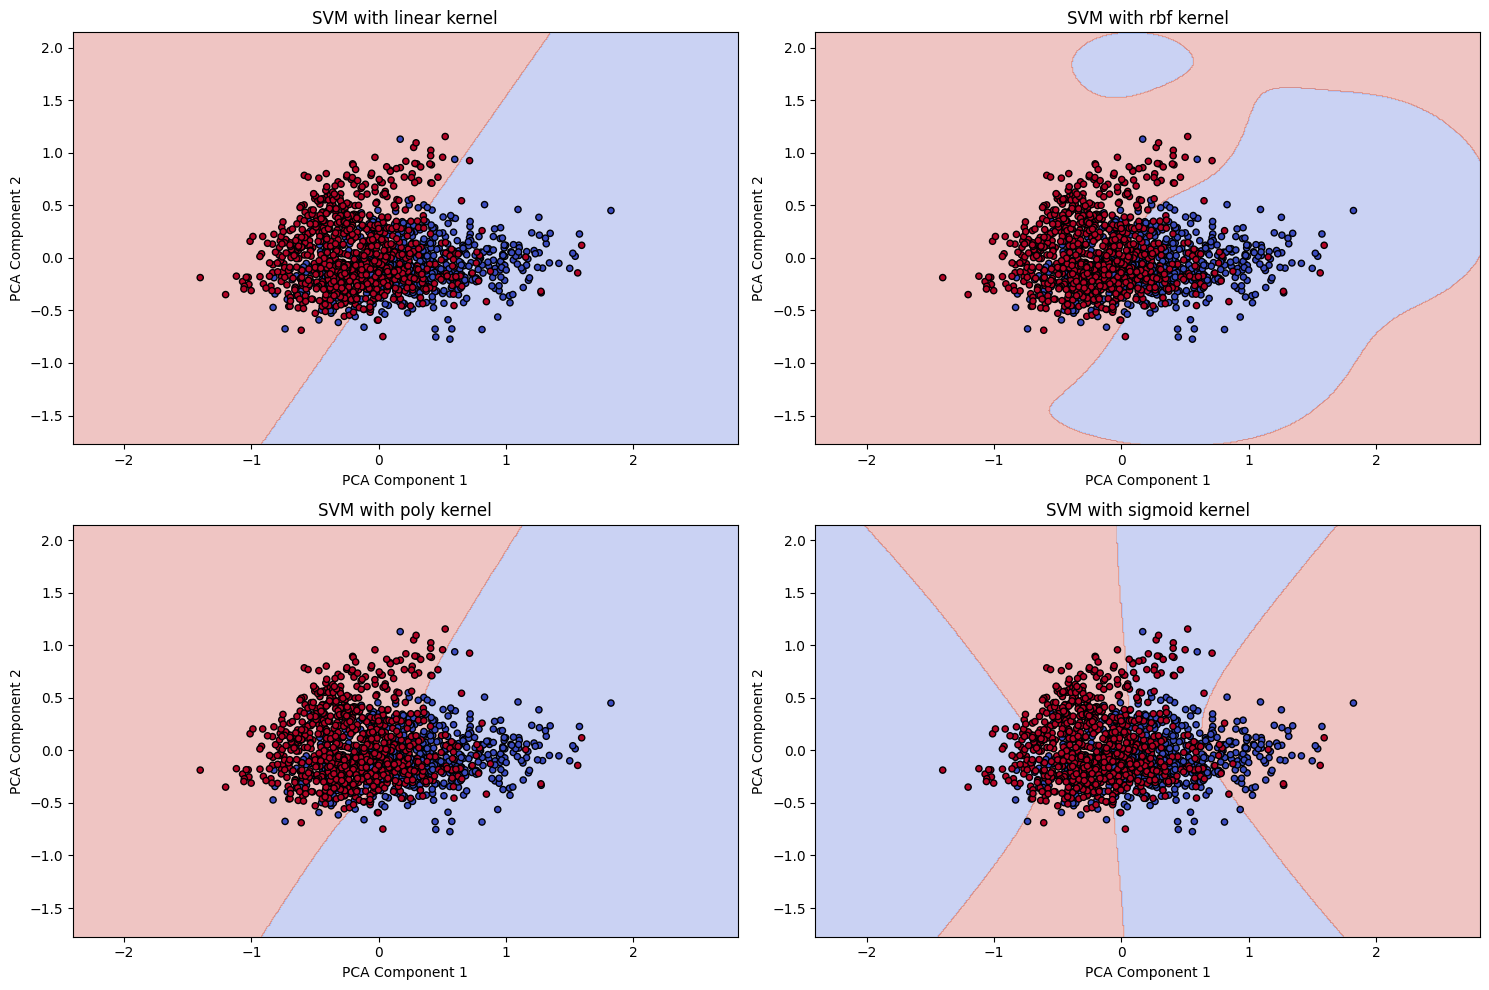

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import cv2
import mahotas

# --- Step 2: Apply PCA to reduce to 2 dimensions ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(rescaled_features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.3, random_state=42, stratify=target)

# --- Step 3: Train SVM models with different kernels ---
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
models = [SVC(kernel=k, random_state=42).fit(X_train, y_train) for k in kernels]

# --- Step 4: Plot the decision boundaries ---
# Create a mesh to plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Plot each kernel's decision boundary
plt.figure(figsize=(15, 10))
for i, (model, kernel) in enumerate(zip(models, kernels), start=1):
    plt.subplot(2, 2, i)
    
    # Predict on mesh grid to plot decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
    plt.title(f"SVM with {kernel} kernel")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


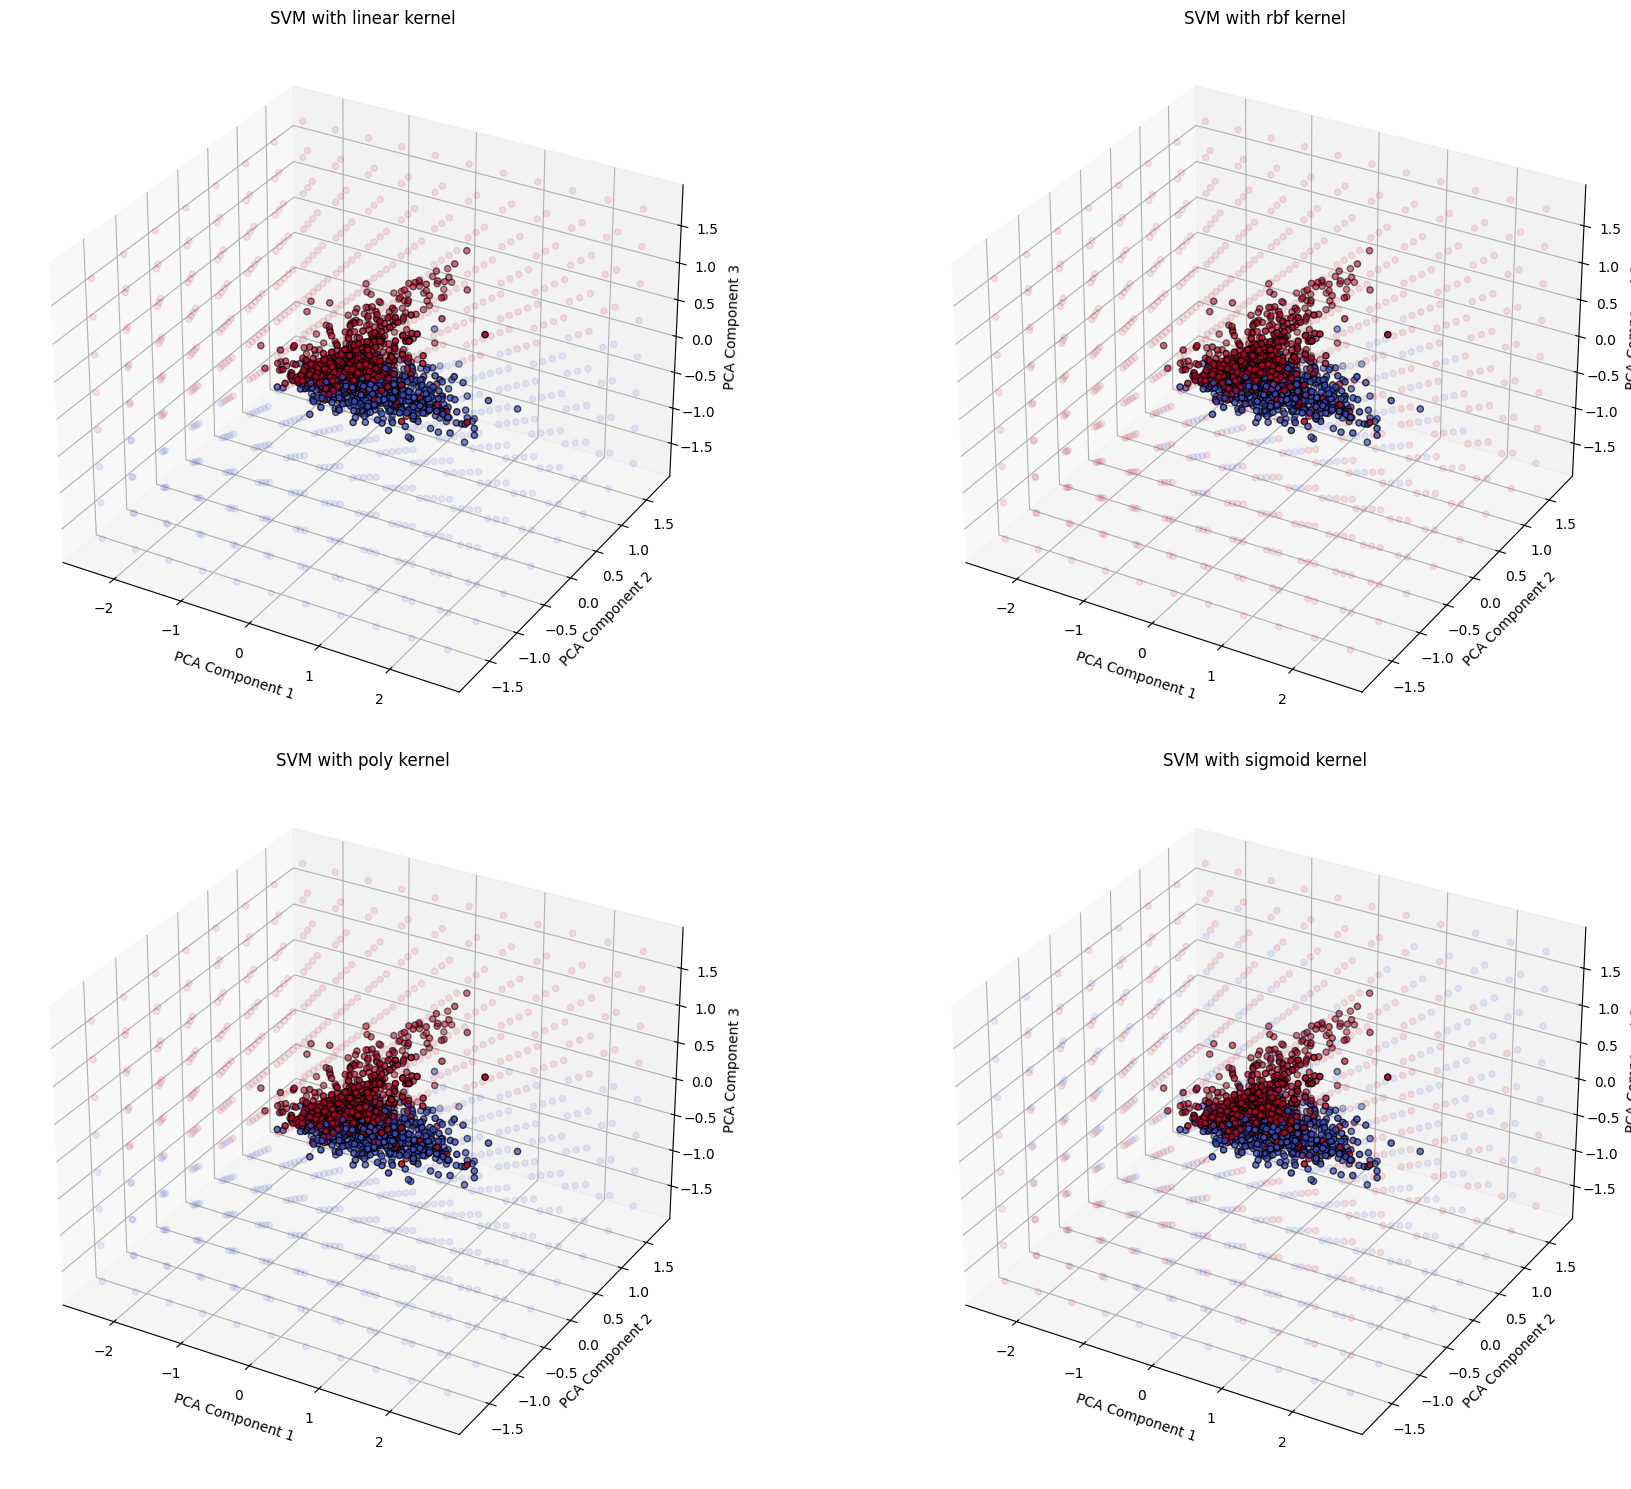

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import cv2
import mahotas

# Assuming the feature extraction code has been executed and you have `rescaled_features` and `target` defined.

# --- Step 1: Scale features if not already scaled ---
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)  # This step is optional if you already did it.

# Encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)

# --- Step 2: Apply PCA to reduce to 3 dimensions ---
pca = PCA(n_components=3)
X_pca = pca.fit_transform(rescaled_features)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.3, random_state=42, stratify=target)

# --- Step 3: Train SVM models with different kernels ---
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
models = [SVC(kernel=k, random_state=42).fit(X_train, y_train) for k in kernels]

# --- Step 4: Plot the decision boundaries in 3D ---
# Create a mesh grid for 3D plotting
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
z_min, z_max = X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1

# Generate a grid of points
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, 0.5),
                         np.arange(y_min, y_max, 0.5),
                         np.arange(z_min, z_max, 0.5))

# Plot each kernel's decision boundary in 3D
fig = plt.figure(figsize=(20, 15))
for i, (model, kernel) in enumerate(zip(models, kernels), start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    
    # Predict on mesh grid to plot decision boundary
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    ax.scatter(xx, yy, zz, c=Z, alpha=0.1, cmap=plt.cm.coolwarm)
    
    # Scatter plot the training points
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=target, cmap=plt.cm.coolwarm, edgecolor='k', s=20)
    
    # Set titles and labels
    ax.set_title(f"SVM with {kernel} kernel")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")

plt.tight_layout()
plt.show()


Training set label distribution: [504 640]
Testing set label distribution: [126 160]
Linear SVM Model Accuracy: 94.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       126
           1       0.96      0.94      0.95       160

    accuracy                           0.94       286
   macro avg       0.94      0.94      0.94       286
weighted avg       0.94      0.94      0.94       286


Confusion Matrix:
[[119   7]
 [ 10 150]]


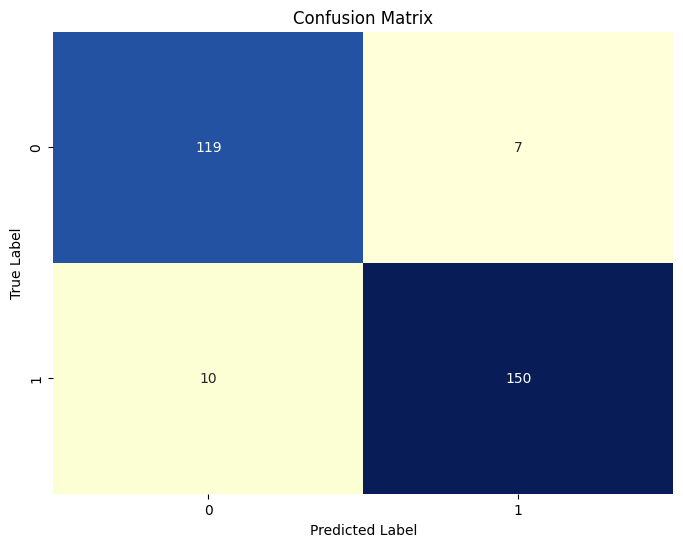

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% 
# Split the data into training and testing sets with stratification to preserve label distribution
X_train, X_test, y_train, y_test = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

# Check the distribution of labels
print("Training set label distribution:", np.bincount(y_train))
print("Testing set label distribution:", np.bincount(y_test))

# %% 
# Initialize the SVM model with a linear kernel
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# %% 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVM Model Accuracy: {accuracy * 100:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# %% 
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



Training set label distribution: [504 640]
Testing set label distribution: [126 160]
RBF SVM Model Accuracy: 94.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       126
           1       0.96      0.93      0.95       160

    accuracy                           0.94       286
   macro avg       0.94      0.94      0.94       286
weighted avg       0.94      0.94      0.94       286


Confusion Matrix:
[[120   6]
 [ 11 149]]


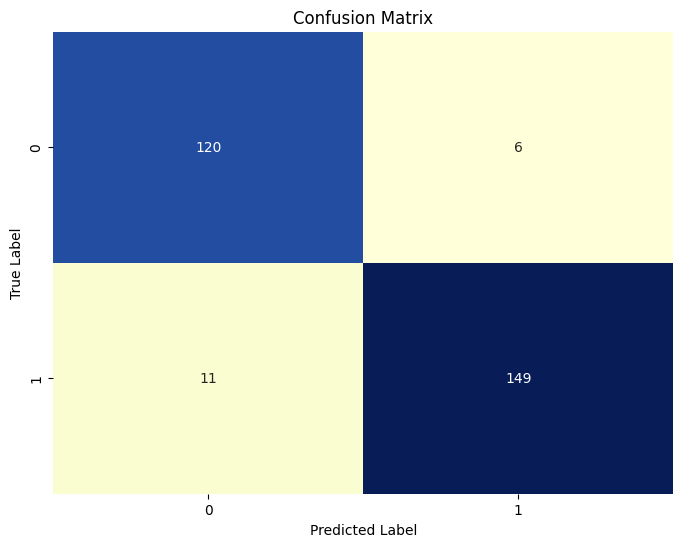

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% 
# Split the data into training and testing sets with stratification to preserve label distribution
X_train, X_test, y_train, y_test = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

# Check the distribution of labels
print("Training set label distribution:", np.bincount(y_train))
print("Testing set label distribution:", np.bincount(y_test))

# 
# Initialize the SVM model with a rbf kernel
svm_model = SVC(kernel='rbf', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# %% 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"RBF SVM Model Accuracy: {accuracy * 100:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# %% 
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Training set label distribution: [504 640]
Testing set label distribution: [126 160]
Poly SVM Model Accuracy: 93.36%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       126
           1       0.94      0.94      0.94       160

    accuracy                           0.93       286
   macro avg       0.93      0.93      0.93       286
weighted avg       0.93      0.93      0.93       286


Confusion Matrix:
[[117   9]
 [ 10 150]]


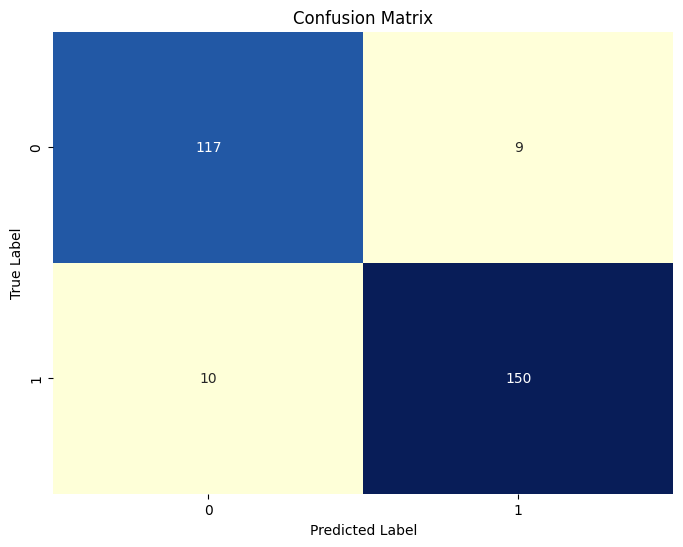

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% 
# Split the data into training and testing sets with stratification to preserve label distribution
X_train, X_test, y_train, y_test = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

# Check the distribution of labels
print("Training set label distribution:", np.bincount(y_train))
print("Testing set label distribution:", np.bincount(y_test))

# Initialize the SVM model with a poly kernel
svm_model = SVC(kernel='poly',degree=4, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# %% 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Poly SVM Model Accuracy: {accuracy * 100:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# %% 
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Training set label distribution: [504 640]
Testing set label distribution: [126 160]
Sigmoid SVM Model Accuracy: 91.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       126
           1       0.91      0.94      0.93       160

    accuracy                           0.92       286
   macro avg       0.92      0.91      0.91       286
weighted avg       0.92      0.92      0.92       286


Confusion Matrix:
[[112  14]
 [ 10 150]]


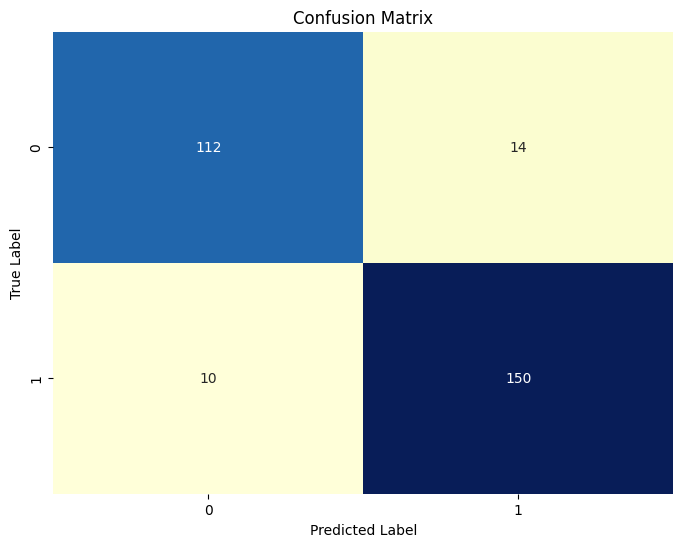

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% 
# Split the data into training and testing sets with stratification to preserve label distribution
X_train, X_test, y_train, y_test = train_test_split(
    rescaled_features, target, test_size=0.2, random_state=42, stratify=target
)

# Check the distribution of labels
print("Training set label distribution:", np.bincount(y_train))
print("Testing set label distribution:", np.bincount(y_test))

# Initialize the SVM model with a sigmoid kernel
svm_model = SVC(kernel='sigmoid', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_model.predict(X_test)

# %% 
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Sigmoid SVM Model Accuracy: {accuracy * 100:.2f}%")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# %% 
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()